In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor

#### 10.1. Load Scaled Datasets

We load the scaled datasets from step 9.  
These datasets contain only the selected features, scaled using `RobustScaler`, and are ready for model training and evaluation.

In [2]:
df_train = pd.read_parquet("./data/9/df_train.parquet")
df_test = pd.read_parquet("./data/9/df_test.parquet")
df_val = pd.read_parquet("./data/9/df_val.parquet")

#### 10.1. Separate Features and Target

We split each dataset into:
- **X**: the feature matrix containing predictors
- **y**: the target column `isFraud`

This allows us to pass the features and labels separately to machine learning models and evaluation functions.

In [3]:
feature_cols = df_train.columns.drop("isFraud")
X_train, y_train = df_train[feature_cols], df_train["isFraud"]
X_val, y_val = df_val[feature_cols], df_val["isFraud"]
X_test, y_test = df_test[feature_cols], df_test["isFraud"]

#### 10.2. Define Model Evaluation Function

The `evaluate_model` function performs a comprehensive evaluation for supervised models:
- Predicts labels and probabilities
- Computes accuracy, precision, recall, F1-score, and ROC-AUC
- Prints a detailed classification report
- Plots a confusion matrix for visual inspection of performance

This function can be reused for training, validation, or test datasets.

In [4]:
def evaluate_model(model, X, y, title="Dataset"):
    """Evaluate model performance on a given dataset."""
    preds = model.predict(X)
    proba = model.predict_proba(X)[:, 1]

    print("\n-------------------------------------------")
    print(f"Evaluation on: {title}")
    print("-------------------------------------------")
    print(f"Accuracy:       {accuracy_score(y, preds):.4f}")
    print(f"Precision:      {precision_score(y, preds):.4f}")
    print(f"Recall:         {recall_score(y, preds):.4f}")
    print(f"F1-score:       {f1_score(y, preds):.4f}")
    print(f"ROC-AUC:        {roc_auc_score(y, proba):.4f}")

    print("\nClassification report:")
    print(classification_report(y, preds, digits=4))

    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

#### 10.3. Define Local Outlier Factor (LOF) Evaluation Function

The `evaluate_lof` function adapts the Local Outlier Factor model for fraud detection:
- LOF outputs -1 for outliers, which we interpret as potential fraud
- Converts LOF predictions into binary labels
- Computes standard classification metrics (accuracy, precision, recall, F1, ROC-AUC)
- Prints a classification report and plots a confusion matrix

This allows us to compare unsupervised anomaly detection methods to supervised classifiers.

In [5]:
def evaluate_lof(model, X, y, title="Dataset"):
    preds_lof = model.predict(X)
    
    preds = np.where(preds_lof == -1, 1, 0)
    
    scores = -model.decision_function(X)
    
    print("\n-------------------------------------------")
    print(f"Evaluation on: {title}")
    print("-------------------------------------------")
    print(f"Accuracy:       {accuracy_score(y, preds):.4f}")
    print(f"Precision:      {precision_score(y, preds, zero_division=0):.4f}")
    print(f"Recall:         {recall_score(y, preds, zero_division=0):.4f}")
    print(f"F1-score:       {f1_score(y, preds, zero_division=0):.4f}")
    print(f"ROC-AUC:        {roc_auc_score(y, scores):.4f}")
    
    print("\nClassification report:")
    print(classification_report(y, preds, digits=4, zero_division=0))
    
    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

#### 10.4. Random Forest Classifier

We train a Random Forest model with the following hyperparameters:
- `n_estimators=200`: number of trees in the forest
- `max_depth=10`: maximum depth of each tree to prevent overfitting
- `min_samples_split=5` and `min_samples_leaf=3`: control tree growth
- `max_features='sqrt'`: uses square root of features for each split
- `random_state=42` and `n_jobs=-1`: for reproducibility and parallel computation

After training, we evaluate performance on both the training and test sets using the `evaluate_model` function.


-------------------------------------------
Evaluation on: Training Set
-------------------------------------------
Accuracy:       0.7041
Precision:      0.7020
Recall:         0.7095
F1-score:       0.7057
ROC-AUC:        0.7894

Classification report:
              precision    recall  f1-score   support

         0.0     0.7064    0.6988    0.7025     26646
         1.0     0.7020    0.7095    0.7057     26646

    accuracy                         0.7041     53292
   macro avg     0.7042    0.7041    0.7041     53292
weighted avg     0.7042    0.7041    0.7041     53292



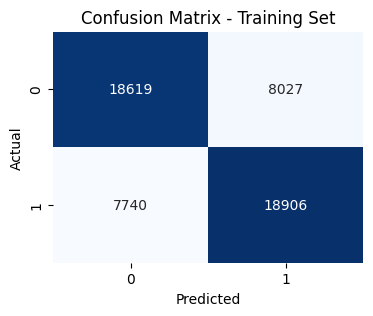


-------------------------------------------
Evaluation on: Test Set
-------------------------------------------
Accuracy:       0.5273
Precision:      0.0015
Recall:         0.5534
F1-score:       0.0031
ROC-AUC:        0.5682

Classification report:
              precision    recall  f1-score   support

         0.0     0.9989    0.5273    0.6902    314588
         1.0     0.0015    0.5534    0.0031       412

    accuracy                         0.5273    315000
   macro avg     0.5002    0.5403    0.3466    315000
weighted avg     0.9976    0.5273    0.6893    315000



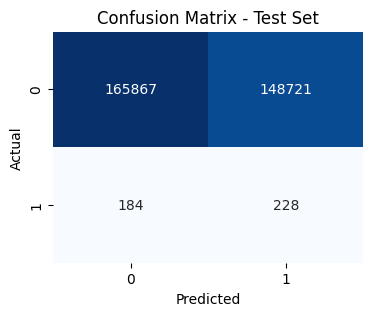

In [6]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

evaluate_model(model, X_train, y_train, title="Training Set")
evaluate_model(model, X_test, y_test, title="Test Set")

#### 10.5. XGBoost Classifier

We train an XGBoost model configured for tabular fraud detection:
- `n_estimators=200` and `max_depth=10` to control complexity
- `learning_rate=0.1` to balance speed and convergence
- `subsample=0.8` and `colsample_bytree=0.8` for regularization
- `eval_metric='logloss'` and `use_label_encoder=False` to comply with latest XGBoost version
- `random_state=42` and `n_jobs=-1` for reproducibility and parallelization

The model is then evaluated on training and test sets with `evaluate_model`.

c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:34:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



-------------------------------------------
Evaluation on: XGBoost - Training Set
-------------------------------------------
Accuracy:       0.9601
Precision:      0.9596
Recall:         0.9606
F1-score:       0.9601
ROC-AUC:        0.9939

Classification report:
              precision    recall  f1-score   support

         0.0     0.9606    0.9595    0.9600     26646
         1.0     0.9596    0.9606    0.9601     26646

    accuracy                         0.9601     53292
   macro avg     0.9601    0.9601    0.9601     53292
weighted avg     0.9601    0.9601    0.9601     53292



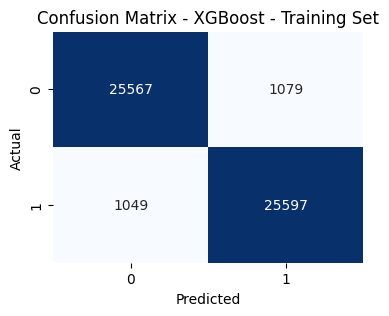


-------------------------------------------
Evaluation on: XGBoost - Test Set
-------------------------------------------
Accuracy:       0.5856
Precision:      0.0020
Recall:         0.6189
F1-score:       0.0039
ROC-AUC:        0.6529

Classification report:
              precision    recall  f1-score   support

         0.0     0.9991    0.5855    0.7384    314588
         1.0     0.0020    0.6189    0.0039       412

    accuracy                         0.5856    315000
   macro avg     0.5006    0.6022    0.3711    315000
weighted avg     0.9978    0.5856    0.7374    315000



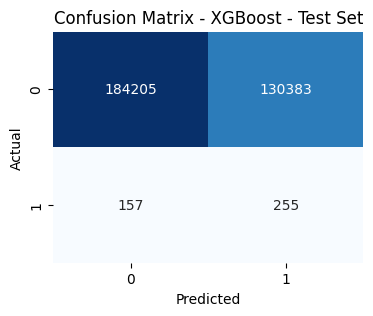

In [7]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

evaluate_model(xgb_model, X_train, y_train, title="XGBoost - Training Set")
evaluate_model(xgb_model, X_test, y_test, title="XGBoost - Test Set")

#### 10.5. LightGBM Classifier

We train a LightGBM classifier with similar settings:
- `n_estimators=200`, `max_depth=10`, and `num_leaves=31` control tree complexity
- `learning_rate=0.1`, `subsample=0.8`, and `colsample_bytree=0.8` reduce overfitting
- `random_state=42` and `n_jobs=-1` ensure reproducibility and parallel execution
- `verbose=-1` suppresses unnecessary output

Evaluation is performed on both training and test sets using `evaluate_model`.


-------------------------------------------
Evaluation on: LightGBM - Training Set
-------------------------------------------
Accuracy:       0.7252
Precision:      0.7235
Recall:         0.7290
F1-score:       0.7262
ROC-AUC:        0.8141

Classification report:
              precision    recall  f1-score   support

         0.0     0.7269    0.7214    0.7242     26646
         1.0     0.7235    0.7290    0.7262     26646

    accuracy                         0.7252     53292
   macro avg     0.7252    0.7252    0.7252     53292
weighted avg     0.7252    0.7252    0.7252     53292



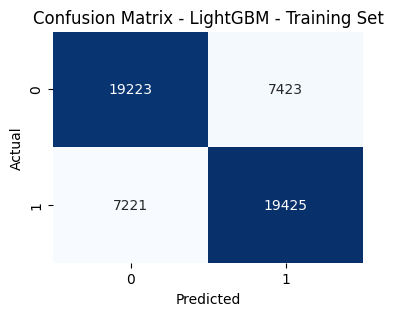


-------------------------------------------
Evaluation on: LightGBM - Test Set
-------------------------------------------
Accuracy:       0.5372
Precision:      0.0017
Recall:         0.5874
F1-score:       0.0033
ROC-AUC:        0.5771

Classification report:
              precision    recall  f1-score   support

         0.0     0.9990    0.5372    0.6987    314588
         1.0     0.0017    0.5874    0.0033       412

    accuracy                         0.5372    315000
   macro avg     0.5003    0.5623    0.3510    315000
weighted avg     0.9977    0.5372    0.6977    315000



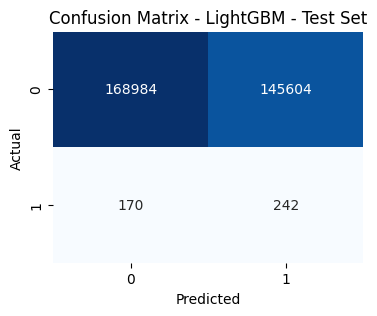

In [8]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

evaluate_model(lgb_model, X_train, y_train, title="LightGBM - Training Set")
evaluate_model(lgb_model, X_test, y_test, title="LightGBM - Test Set")

#### 10.6. Logistic Regression

We train a logistic regression model for baseline comparison:
- `max_iter=1000` ensures convergence
- `class_weight='balanced'` compensates for class imbalance
- `solver='saga'` and `penalty='l2'` provide efficient optimization
- `random_state=42` and `n_jobs=-1` for reproducibility and speed

Performance is assessed on training and test sets with `evaluate_model`.


-------------------------------------------
Evaluation on: Logistic Regression - Training Set
-------------------------------------------
Accuracy:       0.5110
Precision:      0.5103
Recall:         0.5449
F1-score:       0.5270
ROC-AUC:        0.5154

Classification report:
              precision    recall  f1-score   support

         0.0     0.5118    0.4770    0.4938     26646
         1.0     0.5103    0.5449    0.5270     26646

    accuracy                         0.5110     53292
   macro avg     0.5110    0.5110    0.5104     53292
weighted avg     0.5110    0.5110    0.5104     53292



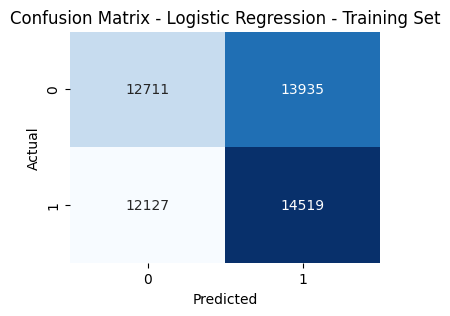


-------------------------------------------
Evaluation on: Logistic Regression - Test Set
-------------------------------------------
Accuracy:       0.4746
Precision:      0.0013
Recall:         0.5316
F1-score:       0.0026
ROC-AUC:        0.5149

Classification report:
              precision    recall  f1-score   support

         0.0     0.9987    0.4745    0.6433    314588
         1.0     0.0013    0.5316    0.0026       412

    accuracy                         0.4746    315000
   macro avg     0.5000    0.5030    0.3230    315000
weighted avg     0.9974    0.4746    0.6425    315000



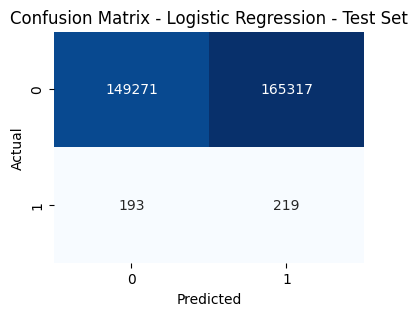

In [9]:
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    solver='saga',
    penalty='l2'
)

lr_model.fit(X_train, y_train)

evaluate_model(lr_model, X_train, y_train, title="Logistic Regression - Training Set")
evaluate_model(lr_model, X_test, y_test, title="Logistic Regression - Test Set")

#### 10.7. Local Outlier Factor (LOF)

LOF is an unsupervised anomaly detection method adapted for fraud detection:
- We sample up to 50,000 training instances to reduce computation
- `n_neighbors=20` defines the local neighborhood
- `contamination=0.1` specifies the expected fraction of outliers
- `novelty=True` allows predicting new unseen data
- `n_jobs=-1` enables parallel computation

We evaluate the LOF model on training and test sets using `evaluate_lof`, converting outliers into predicted fraud labels.

c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



-------------------------------------------
Evaluation on: LOF - Training Set
-------------------------------------------
Accuracy:       0.4996
Precision:      0.4976
Recall:         0.0900
F1-score:       0.1524
ROC-AUC:        0.4851

Classification report:
              precision    recall  f1-score   support

         0.0     0.4998    0.9091    0.6450     26646
         1.0     0.4976    0.0900    0.1524     26646

    accuracy                         0.4996     53292
   macro avg     0.4987    0.4996    0.3987     53292
weighted avg     0.4987    0.4996    0.3987     53292



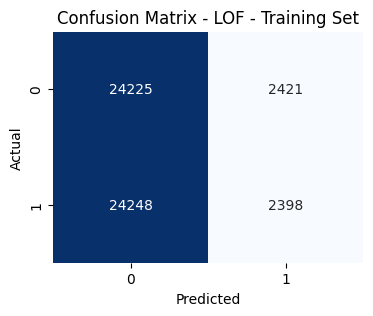

c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



-------------------------------------------
Evaluation on: LOF - Test Set
-------------------------------------------
Accuracy:       0.8927
Precision:      0.0011
Recall:         0.0874
F1-score:       0.0021
ROC-AUC:        0.4802

Classification report:
              precision    recall  f1-score   support

         0.0     0.9987    0.8937    0.9433    314588
         1.0     0.0011    0.0874    0.0021       412

    accuracy                         0.8927    315000
   macro avg     0.4999    0.4906    0.4727    315000
weighted avg     0.9974    0.8927    0.9421    315000



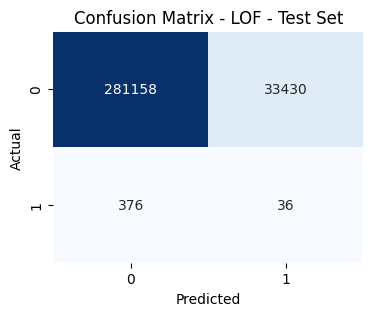

In [10]:
sample_size = min(50000, len(X_train))

X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

lof_model = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.1,
    novelty=True,
    n_jobs=-1
)

lof_model.fit(X_train_sample)

evaluate_lof(lof_model, X_train, y_train, title="LOF - Training Set")
evaluate_lof(lof_model, X_test, y_test, title="LOF - Test Set")

#### 10.8. Model Performance Comparison

In this section, we systematically compare the performance of all trained models on the test set. This includes:

- **Random Forest**
- **XGBoost**
- **LightGBM**
- **Logistic Regression**
- **Local Outlier Factor (LOF, anomaly detection)**

### Steps:

1. **Compute Metrics**  
   We calculate key performance metrics for each model:
   - **Accuracy**: overall correctness
   - **Precision**: proportion of predicted frauds that are actual frauds
   - **Recall**: proportion of actual frauds detected
   - **F1-Score**: harmonic mean of precision and recall
   - **ROC-AUC**: ability to distinguish between fraud and non-fraud across thresholds  

   LOF predictions are converted from anomaly detection outputs to fraud labels.

2. **Store Metrics in a DataFrame**  
   All results are stored in `comparison_df` for easier visualization and comparison.

3. **Identify Best Models**  
   For each metric, we identify which model achieved the highest score.

4. **Visualize Comparison**  
   - Horizontal bar plots show the performance of all models per metric.
   - The best-performing model for each metric is highlighted in **gold**.
   - This helps quickly identify the strongest model for each evaluation criterion.

Notes:
- Highlighting the best models allows us to assess trade-offs, e.g., a model may have the highest ROC-AUC but lower precision.
- LOF is included as an anomaly detection baseline, useful for unsupervised fraud detection scenarios.
- Visualization ensures interpretability and communicates results clearly to stakeholders.

Overall, this comparison provides a comprehensive overview of model performance, guiding the choice of the best model for deployment.

c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\nicol\Documents\ESILV\S9\Project #\python_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
          Random Forest  0.527286   0.001531 0.553398  0.003053 0.568245
                XGBoost  0.585587   0.001952 0.618932  0.003892 0.652899
               LightGBM  0.537225   0.001659 0.587379  0.003309 0.577084
    Logistic Regression  0.474571   0.001323 0.531553  0.002639 0.514884
LOF (Anomaly Detection)  0.892679   0.001076 0.087379  0.002125 0.480168
   • Accuracy    : LOF (Anomaly Detection)   (0.8927)
   • Precision   : XGBoost                   (0.0020)
   • Recall      : XGBoost                   (0.6189)
   • F1-Score    : XGBoost                   (0.0039)
   • ROC-AUC     : XGBoost                   (0.6529)


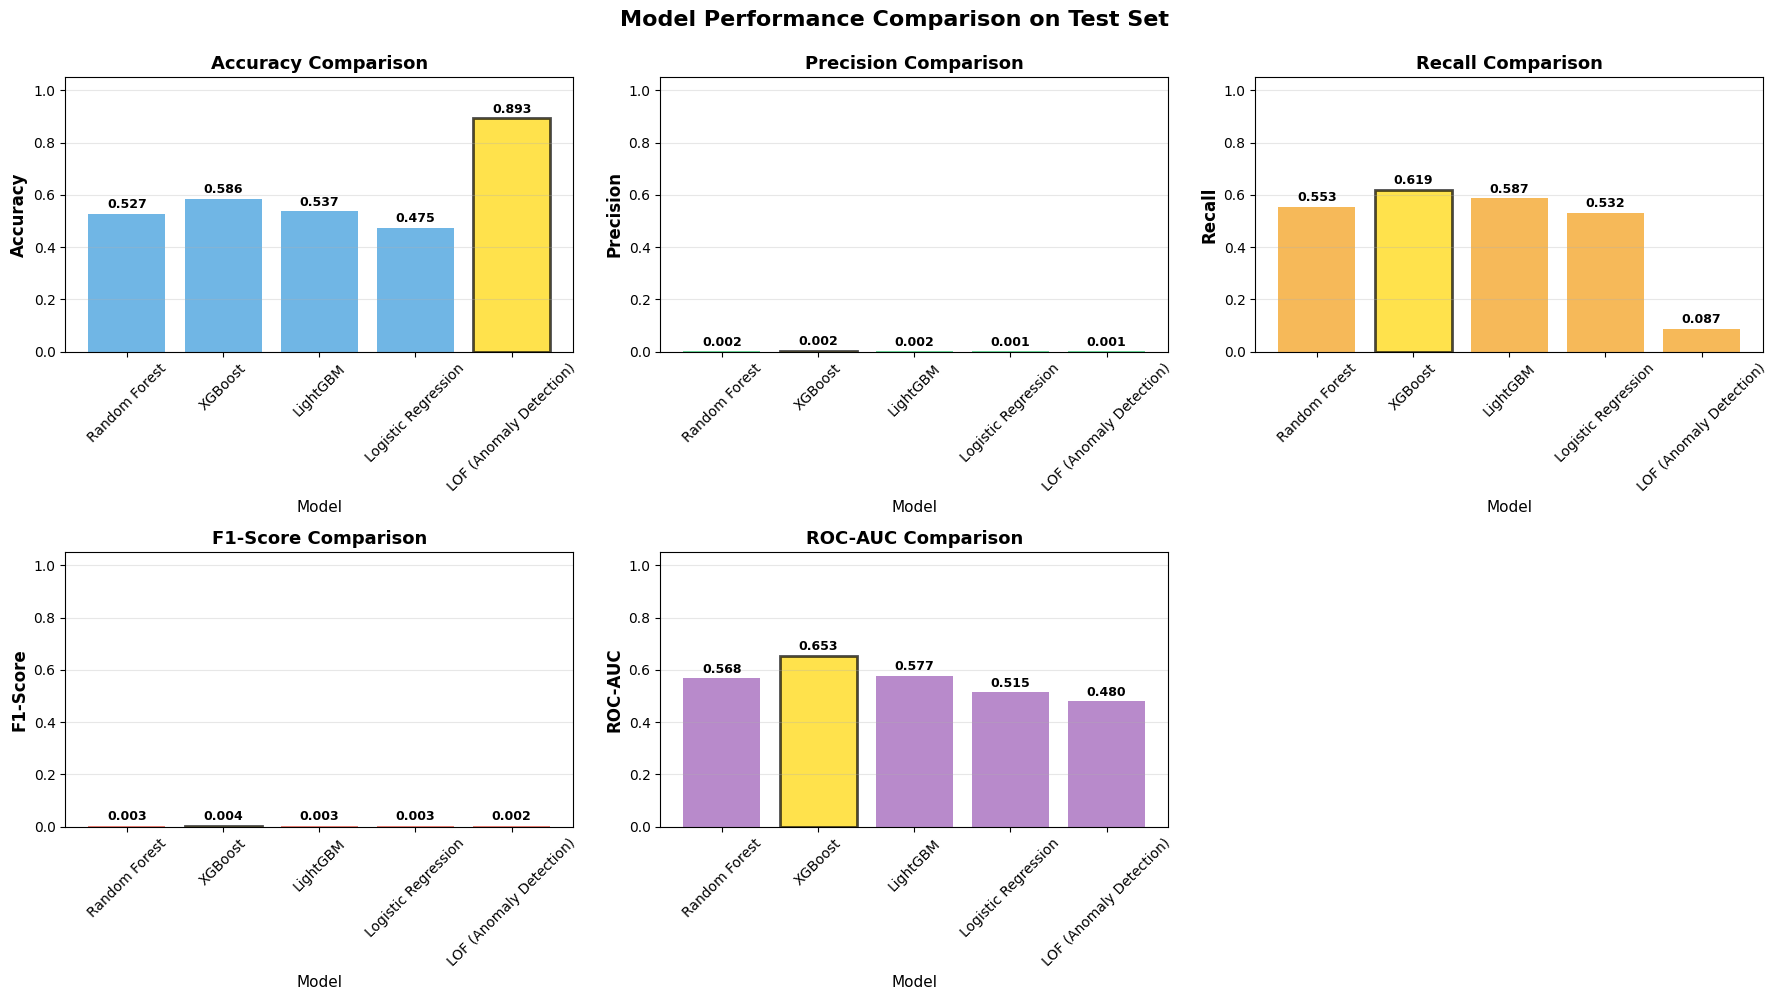

In [11]:
comparison_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}

def get_metrics(model, X, y, model_name, is_lof=False):
    if is_lof:
        preds_lof = model.predict(X)
        preds = np.where(preds_lof == -1, 1, 0)
        scores = -model.decision_function(X)
    else:
        preds = model.predict(X)
        scores = model.predict_proba(X)[:, 1]
    
    comparison_results['Model'].append(model_name)
    comparison_results['Accuracy'].append(accuracy_score(y, preds))
    comparison_results['Precision'].append(precision_score(y, preds, zero_division=0))
    comparison_results['Recall'].append(recall_score(y, preds, zero_division=0))
    comparison_results['F1-Score'].append(f1_score(y, preds, zero_division=0))
    comparison_results['ROC-AUC'].append(roc_auc_score(y, scores))

get_metrics(model, X_test, y_test, "Random Forest")
get_metrics(xgb_model, X_test, y_test, "XGBoost")
get_metrics(lgb_model, X_test, y_test, "LightGBM")
get_metrics(lr_model, X_test, y_test, "Logistic Regression")
get_metrics(lof_model, X_test, y_test, "LOF (Anomaly Detection)", is_lof=True)

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"   • {metric:12s}: {best_model:25s} ({best_score:.4f})")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[idx], alpha=0.7)
    
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel('Model', fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    for i, (bar, value) in enumerate(zip(bars, comparison_df[metric])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[5].axis('off')

plt.suptitle('Model Performance Comparison on Test Set', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()